# **INFO5731 In-class Exercise 5**

**This exercise aims to provide a comprehensive learning experience in text analysis and machine learning techniques, focusing on both text classification and clustering tasks.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 40

**Deadline**: This in-class exercise is due at the end of the day tomorrow, at 11:59 PM.

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


## **Question 1 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text classification** as well as the performance evaluation. In addition, you are requried to conduct **10 fold cross validation** (https://scikit-learn.org/stable/modules/cross_validation.html) in the training.



The dataset can be download from canvas. The dataset contains two files train data and test data for sentiment analysis in IMDB review, it has two categories: 1 represents positive and 0 represents negative. You need to split the training data into training and validate data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the classifier. The final trained model was final evaluated on the test data.


**Algorithms:**

*   MultinominalNB
*   SVM
*   KNN
*   Decision tree
*   Random Forest
*   XGBoost
*   Word2Vec
*   BERT

**Evaluation measurement:**


*   Accuracy
*   Recall
*   Precison
*   F-1 score


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.pipeline import make_pipeline
from gensim.downloader import load

# Load a smaller pre-trained model available in gensim (e.g., 'glove-wiki-gigaword-50')
word2vec_model = load('glove-wiki-gigaword-50')

# Function to read the dataset and store it in a DataFrame
def read_dataset(file_path):
    reviews = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(" ", 1)
            if len(parts) == 2:
                label, text = parts
                if label.isdigit():
                    reviews.append((text, int(label)))
    return pd.DataFrame(reviews, columns=['text', 'label'])

# Load the training and testing datasets
train_df = read_dataset('stsa-train.txt')
test_df = read_dataset('stsa-test.txt')

# Use a subset of the training data for faster processing
train_sample = train_df.sample(n=500, random_state=42)
X_train, y_train = train_sample['text'], train_sample['label']
X_test, y_test = test_df['text'], test_df['label']

# TF-IDF vectorizer to convert text data into numerical form
text_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)  # Limited features for quick results

# Machine learning models to evaluate
models = {
    "NaiveBayes": MultinomialNB(),
    "SupportVectorMachine": SVC(kernel='linear'),
    "KNearestNeighbors": KNeighborsClassifier(n_neighbors=3),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(n_estimators=50),  # Fewer estimators for faster runtime
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=50)
}

# Function to train and test a model, and return its performance metrics
def get_model_metrics(model, train_texts, train_labels, test_texts, test_labels):
    pipeline = make_pipeline(text_vectorizer, model)
    pipeline.fit(train_texts, train_labels)
    predictions = pipeline.predict(test_texts)
    acc = accuracy_score(test_labels, predictions)
    rec = recall_score(test_labels, predictions)
    prec = precision_score(test_labels, predictions)
    f1 = f1_score(test_labels, predictions)
    return acc, rec, prec, f1

# Evaluate all models and store their metrics
performance = {}
for model_name, model in models.items():
    acc, rec, prec, f1 = get_model_metrics(model, X_train, y_train, X_test, y_test)
    performance[model_name] = {
        "Accuracy": acc,
        "Recall": rec,
        "Precision": prec,
        "F1 Score": f1
    }

# Display the evaluation metrics for each model
for name, metrics in performance.items():
    print(f"{name} Performance:")
    for metric_name, metric_value in metrics.items():
        print(f"  {metric_name}: {metric_value}")
    print("\n")


import pandas as pd
from gensim.downloader import load
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from transformers import BertTokenizer, BertModel
from sklearn.linear_model import LogisticRegression
import torch
from torch.utils.data import DataLoader, TensorDataset

# Function to read the dataset and sample it if needed
def read_and_sample_data(file_path, sample_size=None):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(" ", 1)
            if len(parts) == 2:
                label, text = parts
                if label.isdigit():
                    data.append((text, int(label)))
    dataset = pd.DataFrame(data, columns=['text', 'label'])
    if sample_size:
        dataset = dataset.sample(n=sample_size, random_state=42)
    return dataset

# Load the training and testing datasets
training_data = read_and_sample_data('stsa-train.txt', sample_size=500)
testing_data = read_and_sample_data('stsa-test.txt', sample_size=200)
train_texts, train_labels = training_data['text'], training_data['label']
test_texts, test_labels = testing_data['text'], testing_data['label']

### Word2Vec Approach ###

# Load a pre-trained Word2Vec model from gensim
word2vec = load('glove-wiki-gigaword-50')

# Function to create sentence embeddings using Word2Vec
def generate_word2vec_embeddings(sentences, model):
    sentence_embeddings = []
    for sentence in sentences:
        words = sentence.split()
        word_embeddings = [model[word] for word in words if word in model]
        if word_embeddings:
            sentence_embedding = sum(word_embeddings) / len(word_embeddings)
        else:
            sentence_embedding = [0] * model.vector_size
        sentence_embeddings.append(sentence_embedding)
    return sentence_embeddings

# Generate Word2Vec embeddings for training and testing
train_embeddings_w2v = generate_word2vec_embeddings(train_texts, word2vec)
test_embeddings_w2v = generate_word2vec_embeddings(test_texts, word2vec)

# Train a logistic regression model on Word2Vec embeddings
w2v_model = LogisticRegression(max_iter=100)
w2v_model.fit(train_embeddings_w2v, train_labels)
w2v_predictions = w2v_model.predict(test_embeddings_w2v)

# Evaluate the Word2Vec model
evaluation_results = {
    'Word2Vec': {
        "Accuracy": accuracy_score(test_labels, w2v_predictions),
        "Recall": recall_score(test_labels, w2v_predictions),
        "Precision": precision_score(test_labels, w2v_predictions),
        "F1 Score": f1_score(test_labels, w2v_predictions)
    }
}

### BERT Approach ###

# Initialize the BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Function to create BERT embeddings
def generate_bert_embeddings(sentences, tokenizer, model, max_len=128):
    input_ids, attention_masks = [], []

    for sentence in sentences:
        encoded = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_masks)
        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # Extract [CLS] token embeddings

    return cls_embeddings

# Generate BERT embeddings for training and testing
train_embeddings_bert = generate_bert_embeddings(train_texts, bert_tokenizer, bert_model)
test_embeddings_bert = generate_bert_embeddings(test_texts, bert_tokenizer, bert_model)

# Train a logistic regression model on BERT embeddings
bert_model_classifier = LogisticRegression(max_iter=100)
bert_model_classifier.fit(train_embeddings_bert, train_labels)
bert_predictions = bert_model_classifier.predict(test_embeddings_bert)

# Evaluate the BERT model
evaluation_results['BERT'] = {
    "Accuracy": accuracy_score(test_labels, bert_predictions),
    "Recall": recall_score(test_labels, bert_predictions),
    "Precision": precision_score(test_labels, bert_predictions),
    "F1 Score": f1_score(test_labels, bert_predictions)
}

# Display the evaluation results for Word2Vec and BERT models
for method_name, metrics in evaluation_results.items():
    print(f"{method_name} Model Results:")
    for metric_name, metric_value in metrics.items():
        print(f"  {metric_name}: {metric_value}")
    print("\n")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:50:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


NaiveBayes Performance:
  Accuracy: 0.6721581548599671
  Recall: 0.7370737073707371
  Precision: 0.6517509727626459
  F1 Score: 0.6917914300464636


SupportVectorMachine Performance:
  Accuracy: 0.6803953871499177
  Recall: 0.6798679867986799
  Precision: 0.6798679867986799
  F1 Score: 0.6798679867986799


KNearestNeighbors Performance:
  Accuracy: 0.6029654036243822
  Recall: 0.35533553355335534
  Precision: 0.7021739130434783
  F1 Score: 0.4718772826880935


DecisionTree Performance:
  Accuracy: 0.5908841295991214
  Recall: 0.5390539053905391
  Precision: 0.6004901960784313
  F1 Score: 0.5681159420289855


RandomForest Performance:
  Accuracy: 0.6073585941790225
  Recall: 0.34763476347634764
  Precision: 0.7214611872146118
  F1 Score: 0.46919079435783223


XGBoost Performance:
  Accuracy: 0.5875892366831411
  Recall: 0.45544554455445546
  Precision: 0.6179104477611941
  F1 Score: 0.5243825205826472


Word2Vec Model Results:
  Accuracy: 0.755
  Recall: 0.7307692307692307
  Precision: 

## **Question 2 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text clustering**.

Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)

**Apply the listed clustering methods to the dataset:**
*   K-means
*   DBSCAN
*   Hierarchical clustering
*   Word2Vec
*   BERT

You can refer to of the codes from  the follwing link below.
https://www.kaggle.com/karthik3890/text-clustering

K-means Silhouette Score: 0.040512292116274426
DBSCAN Silhouette Score: 0.18520553362789438
Hierarchical Clustering Silhouette Score: 0.028340375844807447
Word2Vec K-means Silhouette Score: 0.5142773980594532
BERT K-means Silhouette Score: 0.10397091507911682


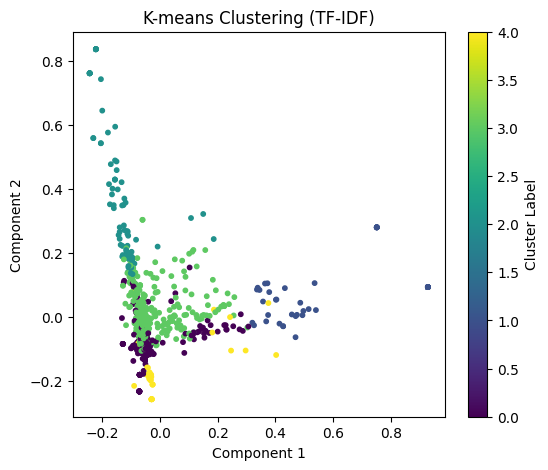

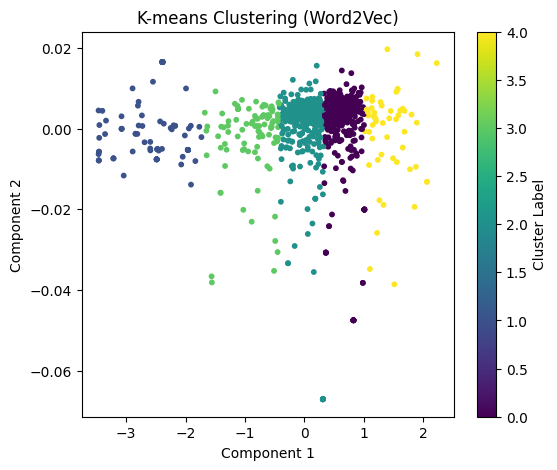

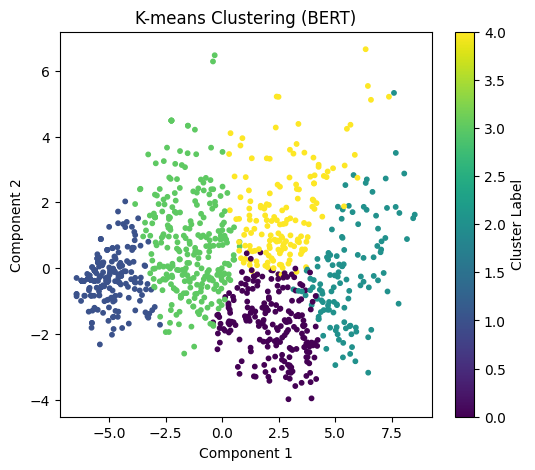

In [9]:
# Write your code here
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# List to temporarily hold valid data chunks
data_parts = []

# Load data in smaller batches to avoid memory issues and clean invalid rows
try:
    chunks = pd.read_csv('Amazon_Unlocked_Mobile.csv', usecols=['Reviews'],
                         chunksize=10000, on_bad_lines='skip', engine='python')
    for part in chunks:
        data_parts.append(part.dropna(subset=['Reviews']))
except Exception as error:
    print("Error loading file:", error)

# Combine all cleaned data chunks into a single dataset
dataset = pd.concat(data_parts, ignore_index=True)

# Randomly sample a subset for faster processing if needed
dataset = dataset.sample(n=1000, random_state=42)

# Clean and preprocess the text data
dataset['processed_reviews'] = dataset['Reviews'].str.lower().str.replace('[^a-zA-Z]', ' ', regex=True)

# Convert text data to numeric format using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_data = tfidf_vectorizer.fit_transform(dataset['processed_reviews'])

### K-means Clustering ###
kmeans_model = KMeans(n_clusters=5, random_state=42)
kmeans_clusters = kmeans_model.fit_predict(tfidf_data)
kmeans_score = silhouette_score(tfidf_data, kmeans_clusters)
print(f"K-means Silhouette Score: {kmeans_score}")

### DBSCAN Clustering ###
dbscan_model = DBSCAN(eps=0.5, min_samples=5, metric='cosine')
dbscan_clusters = dbscan_model.fit_predict(tfidf_data)
# Calculate silhouette score excluding noise (-1 label)
dbscan_score = silhouette_score(tfidf_data[dbscan_clusters != -1], dbscan_clusters[dbscan_clusters != -1]) if len(set(dbscan_clusters)) > 1 else -1
print(f"DBSCAN Silhouette Score: {dbscan_score}")

### Hierarchical Clustering ###
# Remove rows with all zero values in the TF-IDF matrix
non_zero_data = np.where(tfidf_data.toarray().sum(axis=1) != 0)[0]
filtered_tfidf = tfidf_data[non_zero_data]

# Perform hierarchical clustering on filtered data
hierarchical_model = AgglomerativeClustering(n_clusters=5, metric='cosine', linkage='average')
hierarchical_clusters = hierarchical_model.fit_predict(filtered_tfidf.toarray())
hierarchical_score = silhouette_score(filtered_tfidf, hierarchical_clusters)
print(f"Hierarchical Clustering Silhouette Score: {hierarchical_score}")

### Word2Vec Clustering ###
# Train Word2Vec embeddings on tokenized reviews
tokenized_data = dataset['processed_reviews'].str.split()
word2vec_model = Word2Vec(sentences=tokenized_data, vector_size=100, window=5, min_count=1, workers=4)

# Create sentence-level embeddings by averaging word vectors
def create_sentence_vector(sentence, model):
    words = sentence.split()
    vectors = [model.wv[word] for word in words if word in model.wv]
    return sum(vectors) / len(vectors) if vectors else [0] * model.vector_size

word2vec_data = [create_sentence_vector(review, word2vec_model) for review in dataset['processed_reviews']]

# Perform K-means clustering on Word2Vec embeddings
kmeans_word2vec = KMeans(n_clusters=5, random_state=42)
word2vec_clusters = kmeans_word2vec.fit_predict(word2vec_data)
word2vec_score = silhouette_score(word2vec_data, word2vec_clusters)
print(f"Word2Vec K-means Silhouette Score: {word2vec_score}")

### BERT Embeddings ###
# Load pre-trained BERT model and tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Function to generate embeddings using BERT
def create_bert_embeddings(sentences, tokenizer, model, max_len=128):
    input_ids, attention_masks = [], []

    for sentence in sentences:
        encoded = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_masks)
        return outputs.last_hidden_state[:, 0, :].cpu().numpy()  # Extract CLS token embeddings

bert_data = create_bert_embeddings(dataset['processed_reviews'], bert_tokenizer, bert_model)

# Perform K-means clustering on BERT embeddings
kmeans_bert = KMeans(n_clusters=5, random_state=42)
bert_clusters = kmeans_bert.fit_predict(bert_data)
bert_score = silhouette_score(bert_data, bert_clusters)
print(f"BERT K-means Silhouette Score: {bert_score}")

### Visualization ###
# Reduce dimensions for plotting
pca_model = PCA(n_components=2)
tfidf_2d = pca_model.fit_transform(tfidf_data.toarray())
word2vec_2d = pca_model.fit_transform(word2vec_data)
bert_2d = pca_model.fit_transform(bert_data)

# Plot clusters for each method
# Plot 1: K-means Clustering (TF-IDF)
plt.figure(figsize=(6, 5))
plt.scatter(tfidf_2d[:, 0], tfidf_2d[:, 1], c=kmeans_clusters, cmap='viridis', s=10)
plt.title("K-means Clustering (TF-IDF)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label='Cluster Label')
plt.show()

# Plot 2: K-means Clustering (Word2Vec)
plt.figure(figsize=(6, 5))
plt.scatter(word2vec_2d[:, 0], word2vec_2d[:, 1], c=word2vec_clusters, cmap='viridis', s=10)
plt.title("K-means Clustering (Word2Vec)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label='Cluster Label')
plt.show()

# Plot 3: K-means Clustering (BERT)
plt.figure(figsize=(6, 5))
plt.scatter(bert_2d[:, 0], bert_2d[:, 1], c=bert_clusters, cmap='viridis', s=10)
plt.title("K-means Clustering (BERT)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label='Cluster Label')
plt.show()



**In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.**

K-means, DBSCAN, Hierarchical clustering, Word2Vec and BERT has many different approches and results. K- Means algorithm forms k number of clusters and it is the centroid based algorithm. The clusteres formed are generally of the same size. DBSCAN forms the arbitary shaped clusters and they handles the noise and it is the density based algorithm but in this algorithm we have to tune the paramerters very carefully. Hierarchical clustering builds the dendograms and it offers the more detailed view of the data structure. It is generally used for the large datasets. Word2Vec it is an embedding technique and it captures semantic similarities by mapping words into dense vector spaces, often improving clustering by providing meaningful distances between words. BERT is a transformer-based model and it captures rich contextual embeddings, resulting in deeper semantic understanding and typically more accurate clustering compared to Word2Vec, especially in complex, nuanced text data.



# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises you completed in this assignment.


**(Your submission will not be graded if this question is left unanswered)**



In [6]:
# Your answer here (no code for this question, write down your answer as detail as possible for the above questions):

'''
It is very helpful to understand better about the clustering methods. I found it
very insightful and challenging while completing the assignment and it enhances my skills and understanding ability.


'''

'\nIt is very helpful to understand better about the clustering methods. I found it \nvery insightful and challenging while completing the assignment and it enhances my skills and understanding ability.\n\n\n'